In [61]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import nibabel as nib
from dipy.segment.mask import median_otsu

import importlib
from pathlib import Path

import sys

sys.path.append(str(Path.home() / "Projects" / "MaxEnt" / "Code" / "numpy"))

import Basic_functions as bf
import Synthetic_data as sd
import R_roughness as rr
import D2_admm_solver as das

importlib.reload(bf)
importlib.reload(sd)
importlib.reload(rr)
importlib.reload(das)

<module 'D2_admm_solver' from '/Users/xunan/Projects/MaxEnt/Code/numpy/D2_admm_solver.py'>

In [62]:
data = np.load('/Users/xunan/Projects/MaxEnt/Data/processed_numpy.npz')
Sqs = data['Sqs'][0:30, 0:30, 0:30, :]
Sb0 = data['Sb0'][0:30, 0:30, 0:30, :]
qs = data['qs']
sigma = data['sigma'][0:30, 0:30, 0:30, :]

In [63]:
mask, lin2idx = bf.mask_brain(Sb0, median_radius = 1, numpass = 4, least_size = 300, keep_top = 3)

Number of initial valid regions: 1
Sizes of each regions (1st is background): [26337   663]
Number of kept regions: 1
Sizes of kept regions: [663]


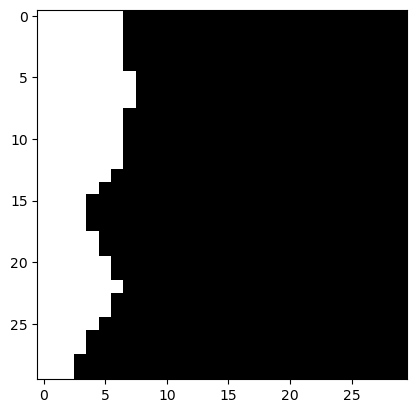

In [64]:
plt.imshow(np.fliplr(np.flipud(mask[29, :, :].T)), cmap='gray')
plt.show()

In [65]:
Sqs   =   Sqs[mask, :].reshape((-1, qs.shape[0]), order = 'C')
sigma = sigma[mask, :].ravel()
sigma[sigma < 0.02] = 0.02

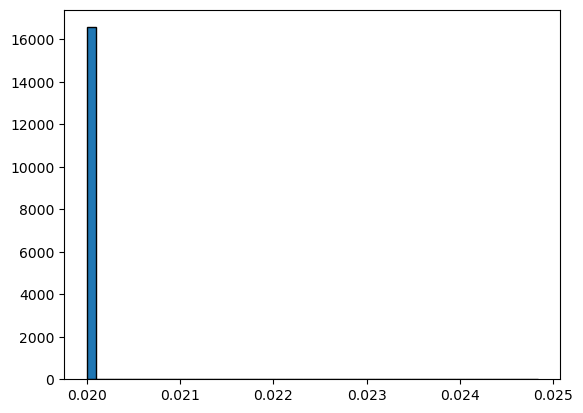

In [76]:
plt.hist(sigma, bins = 50, edgecolor = 'black')
plt.show()

In [75]:
theta1 = np.linspace(0, 3, 50)
theta2 = np.linspace(0, 40, 50)
thetas, weights = bf.Cartesian(theta1, theta2)
R = rr.R_mask(mask, 25, order = 2)

In [67]:
lambdas, f_hat, obj_history = das.admm( qs, thetas, weights, Sqs, sigma = sigma,
                                        R_csr = R, f0 = None, normalize = True,
                                        Lambdas = None, rho = 5e-1, rho_ratio = 3,dynamic_rho = True,
                                        beta = 0.5, c = 1e-4, tol = 1e-2, epsilon = 1e-8, maxiter = 10,
                                        cg_rtol = 1e-10, cg_atol = 1e-50, cg_maxiter = 1000, 
                                        admm_tol = 1e-10, admm_maxiter = 200)


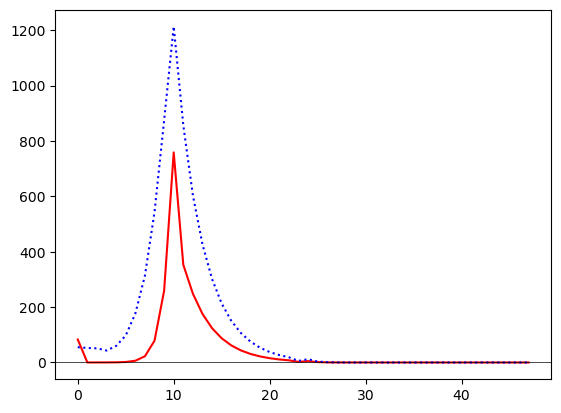

In [68]:
plt.plot(obj_history[1][:], '-', color = 'red', label = 'primal')
plt.plot(obj_history[2][:], ':', color = 'blue', label = 'dual')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.show()


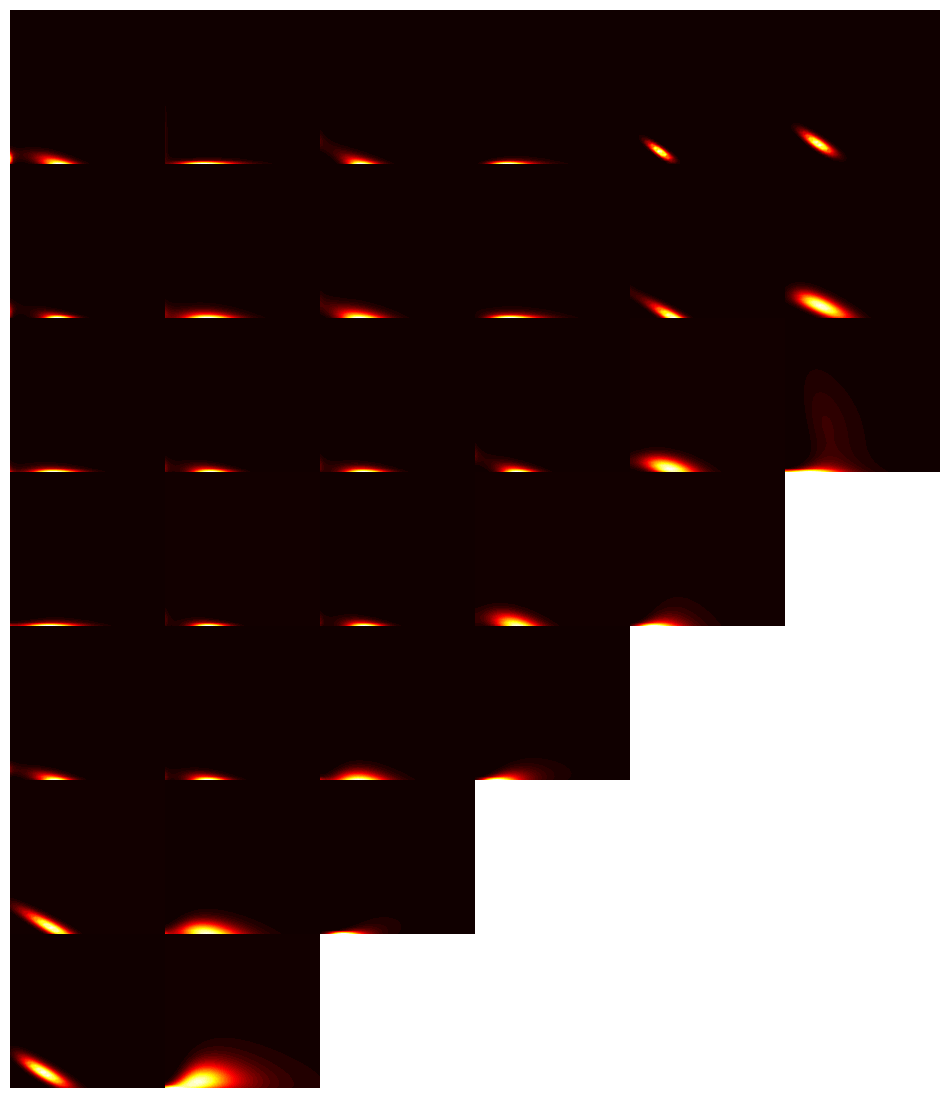

In [69]:
bf.contourf_mask(theta1, theta2, f_hat, lin2idx, axis = 2, slice = 19)